In [1]:
# ## Milo is available from Bioconductor (preferred stable installation)
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("miloR")

# # ## Install development version
# # devtools::install_github("MarioniLab/miloR", ref="devel") 

In [2]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [3]:
anndata <- readRDS('/nfs/team292/lg18/endometriosis/MiloR_objects/nuclei_mesenchymal_SECRETORY_integrated.rds')
anndata

An object of class Seurat 
30066 features across 34432 samples within 1 assay 
Active assay: RNA (30066 features, 0 variable features)
 2 dimensional reductions calculated: X_scVI, UMAP

In [4]:
table(anndata@meta.data[ , c('genotype', 'celltype') ])
table(anndata@meta.data[ , c('Group', 'celltype') ])

        celltype
genotype dStromal_early dStromal_late dStromal_mid
  EX0277            449            55           66
  EX0366            129          4122         1865
  EX0661              2            61            4
  EX0789              2            55           23
  FX0028           1258            19           42
  FX0033            971             4           20
  FX1087            168           180         4392
  FX1100             46           237          376
  FX1106              0            21            2
  FX1130             23            36           21
  FX1156            115           198          481
  FX1163            805            11           23
  FX1170           4133           143          166
  FX1205              0             3            3
  FX1223              8           118           34
  FX1233           1153            42          117
  FX9006           5325           104          303
  FX9008             51           291         1029
  FX9011      

                  celltype
Group              dStromal_early dStromal_late dStromal_mid
  Ctrl_Superficial           1338           537         3057
  Endo_Superficial          13368          7661         8471

In [5]:
anndata_sce <- as.SingleCellExperiment(anndata)

# Visualize the data
Visualise the UMAP embedding for this subset of cells.

We will test for significant differences in abundance of cells between these states, and the associated gene signatures.

class: SingleCellExperiment 
dim: 30066 34432 
metadata(0):
assays(2): counts logcounts
rownames(30066): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(0):
colnames(34432): UA_Endo11460962_AATGGCTCACACACTA
  UA_Endo12296824_AAATGGATCACCTGTC ... UA_Endo12865963_GGTTAACAGATGATTG
  UA_Endo12296824_GAGACCCTCTCATGCC
colData names(53): library StudyName ... celltype ident
reducedDimNames(2): X_SCVI UMAP
mainExpName: RNA
altExpNames(0):

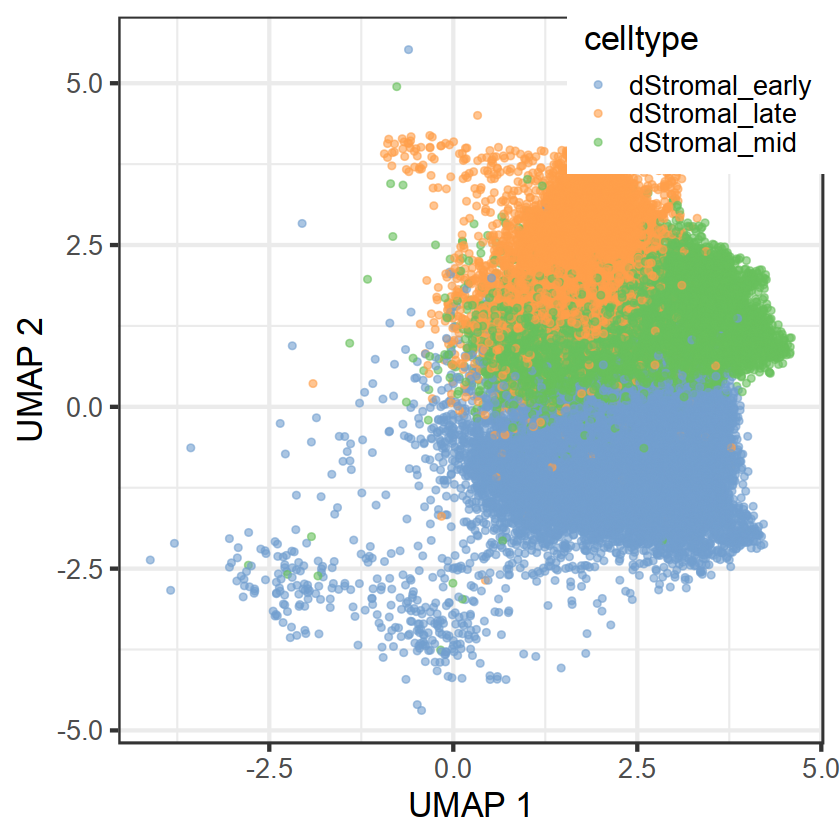

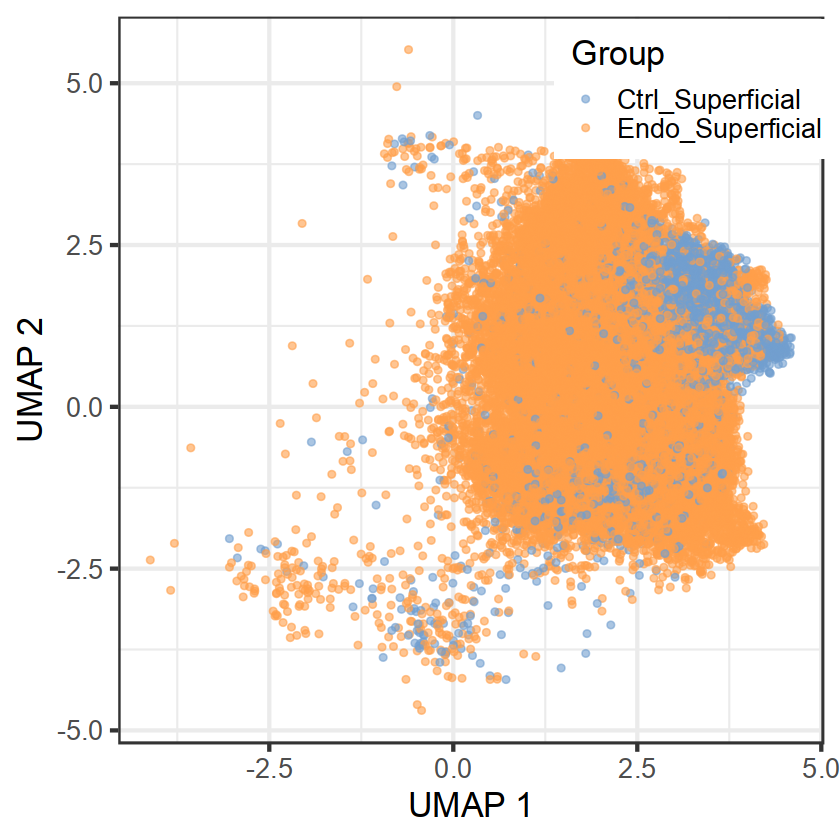

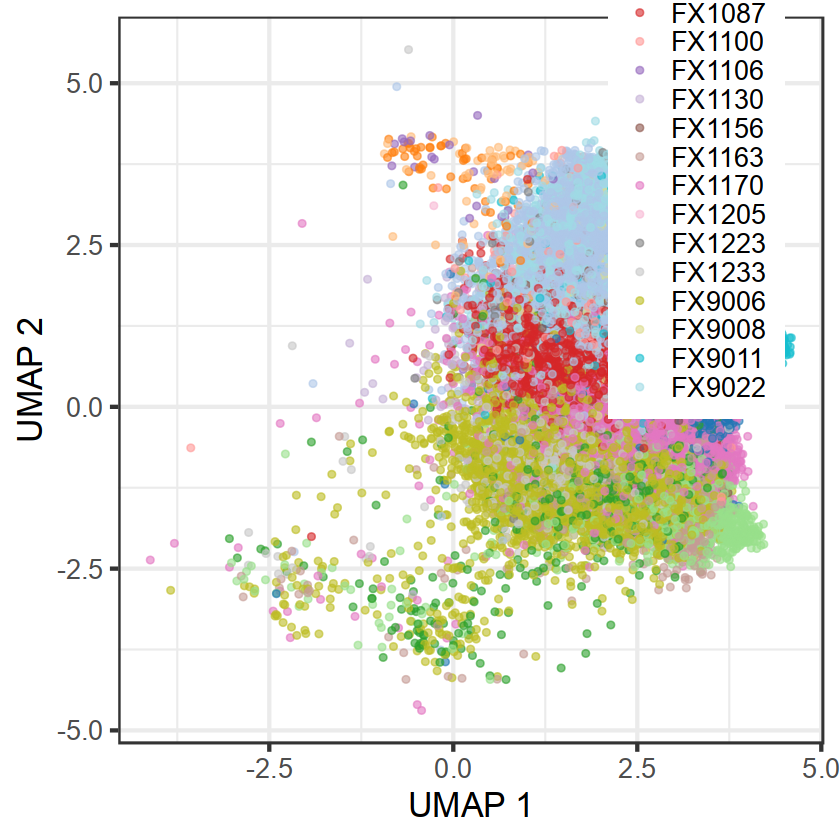

In [6]:
anndata_sce
plotReducedDim(anndata_sce, colour_by="celltype", dimred = "UMAP") + theme_bw(20) + theme(legend.position = c(0.82, 0.9))
plotReducedDim(anndata_sce, colour_by="Group", dimred = "UMAP") + theme_bw(20) + theme(legend.position = c(0.82, 0.9))
plotReducedDim(anndata_sce, colour_by="genotype", dimred = "UMAP") + theme_bw(20) + theme(legend.position = c(0.82, 0.9))

# Differential abundance testing
### Create a Milo object

For differential abundance analysis on graph neighbourhoods we first construct a Milo object. This extends the SingleCellExperiment class to store information about neighbourhoods on the KNN graph.

In [7]:
anndata_milo <- Milo(anndata_sce)
anndata_milo

class: Milo 
dim: 30066 34432 
metadata(0):
assays(2): counts logcounts
rownames(30066): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(0):
colnames(34432): UA_Endo11460962_AATGGCTCACACACTA
  UA_Endo12296824_AAATGGATCACCTGTC ... UA_Endo12865963_GGTTAACAGATGATTG
  UA_Endo12296824_GAGACCCTCTCATGCC
colData names(53): library StudyName ... celltype ident
reducedDimNames(2): X_SCVI UMAP
mainExpName: RNA
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1

### Construct KNN graph

We need to add the KNN graph to the Milo object. This is stored in the graph slot, in igraph format. The miloR package includes functionality to build and store the graph from the PCA dimensions stored in the reducedDim slot. In this case, we specify that we want to build the graph from the MNN corrected PCA dimensions.

For graph building you need to define a few parameters:

 - d: the number of reduced dimensions to use for KNN refinement. We recommend using the same d used for KNN graph building, or to select PCs by inspecting the scree plot.
 
 - k: this affects the power of DA testing, since we need to have enough cells from each sample represented in a neighbourhood to estimate the variance between replicates. On the other side, increasing k too much might lead to over-smoothing. We suggest to start by using the same value for k used for KNN graph building for clustering and UMAP visualization. We will later use some heuristics to evaluate whether the value of k should be increased.

In [8]:
anndata_milo <- buildGraph(anndata_milo, k = 30, d = 30, reduced.dim = "X_SCVI")

Constructing kNN graph with k:30



### Defining representative neighbourhoods on the KNN graph

We define the neighbourhood of a cell, the index, as the group of cells connected by an edge in the KNN graph to the index cell. For efficiency, we don’t test for DA in the neighbourhood of every cell, but we sample as indices a subset of representative cells, using a KNN sampling algorithm used by Gut et al. 2015.

As well as d and k, for sampling we need to define a few additional parameters:

  - prop: the proportion of cells to randomly sample to start with. We suggest using prop=0.1 for datasets of less than 30k cells. For bigger datasets using prop=0.05 should be sufficient (and makes computation faster).
  - refined: indicates whether you want to use the sampling refinement algorith, or just pick cells at random. The default and recommended way to go is to use refinement. 

In [9]:
anndata_milo <- makeNhoods(anndata_milo, prop = 0.1, k = 30, d=30, refined = TRUE, reduced_dims = "X_SCVI")

Checking valid object

Running refined sampling with reduced_dim



Once we have defined neighbourhoods, we plot the distribution of neighbourhood sizes (i.e. how many cells form each neighbourhood) to evaluate whether the value of k used for graph building was appropriate. We can check this out using the plotNhoodSizeHist function.

As a rule of thumb we want to have an average neighbourhood size over 5 x N_samples. If the mean is lower, or if the distribution is

In [10]:
length(unique(colData(anndata_milo)$genotype)) * 5

[1] 100

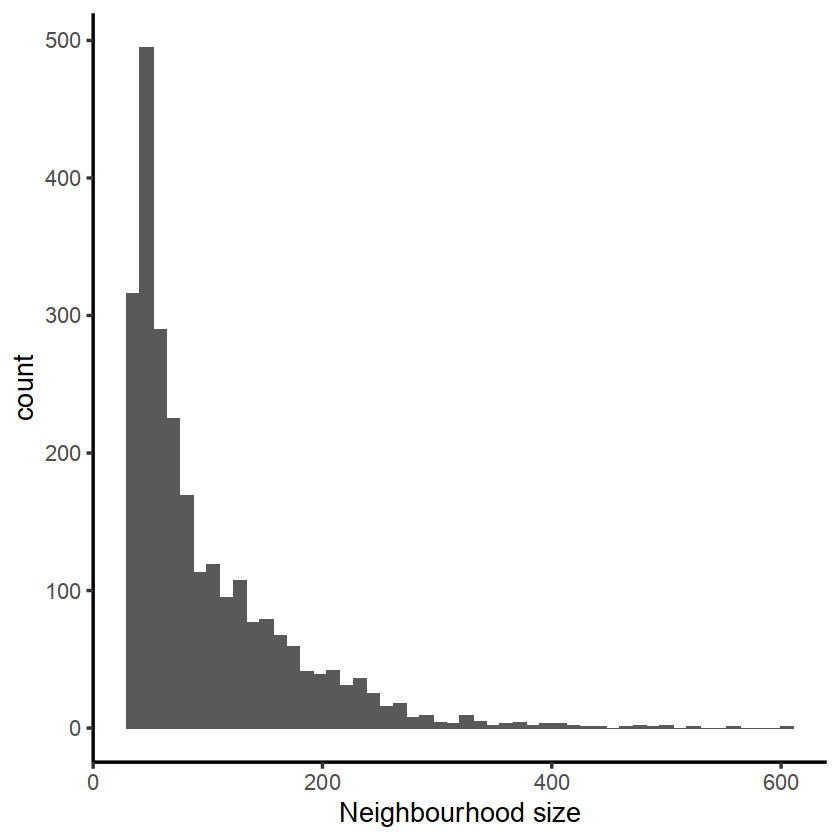

In [11]:
plotNhoodSizeHist(anndata_milo)

### Counting cells in neighbourhoods
Milo leverages the variation in cell numbers between replicates for the same experimental condition to test for differential abundance. Therefore we have to count how many cells from each sample are in each neighbourhood. We need to use the cell metadata and specify which column contains the sample information.



In [12]:
anndata_milo <- countCells(anndata_milo, meta.data = as.data.frame(colData(anndata_milo)), sample="Library_genotype")

Checking meta.data validity

Counting cells in neighbourhoods



This adds to the Milo object a n×m matrix, where n is the number of neighbourhoods and m is the number of experimental samples. Values indicate the number of cells from each sample counted in a neighbourhood. This count matrix will be used for DA testing.



In [13]:
head(nhoodCounts(anndata_milo))

  [[ suppressing 23 column names ‘UA_Endo11173480_FX1205’, ‘UA_Endo11173481_FX9022’, ‘UA_Endo11173482_FX9011’ ... ]]



6 x 23 sparse Matrix of class "dgCMatrix"
                                                          
1 .  2  1   1  . 7 3 . 7 3 . 1 . .  1 . 7 36 . 12 25   4 .
2 . 11  2  16  . . . . . . . . . .  . 3 .  . .  .  3  10 .
3 . 39  .  24 19 3 1 1 3 3 . 3 . .  1 . 2  5 . 26  9   5 .
4 . 68  4  70  . . 1 . 1 . . 1 1 .  1 4 .  1 1  2  4  16 .
5 1 48 11 110  5 1 4 . 5 . . 2 1 . 12 3 1  1 1 27 42 206 .
6 . 14  .  11  2 . . . 6 2 . . . .  . 1 .  1 . 85 18  25 .

## Defining experimental design
Now we are all set to test for differential abundance in neighbourhoods. We implement this hypothesis testing in a generalized linear model (GLM) framework, specifically using the Negative Binomial GLM implementation in edgeR.

We first need to think about our experimental design. The design matrix should match each sample to the experimental condition of interest for DA testing. 

In this case, we want to detect DA between Endometriosis/controls, stored in the `Group` or `Ectopic_EcP_EcO_EcPA_EcP.D` columns of the dataset colData. We also include the `Library_genotype` column in the design matrix. This represents a known technical covariate that we want to account for in DA testing.



In [14]:
colData(anndata_milo)$sample = colData(anndata_milo)$Library_genotype

In [15]:
anndata_design <- data.frame(colData(anndata_milo))[,c("Group", "Library_genotype", "dataset")]

## Convert batch info from integer to factor
anndata_design$Library_genotype <- as.factor(anndata_design$Library_genotype) 
anndata_design$dataset <- as.factor(anndata_design$dataset) 
anndata_design <- distinct(anndata_design)
rownames(anndata_design) <- anndata_design$Library_genotype

anndata_design

,Group,Library_genotype,dataset
,<fct>,<fct>,<fct>
UA_Endo11460962_FX1170,Endo_Superficial,UA_Endo11460962_FX1170,Mareckova_Nuclei
UA_Endo12296824_FX9008,Ctrl_Superficial,UA_Endo12296824_FX9008,Mareckova_Nuclei
UA_Endo11173481_FX9022,Endo_Superficial,UA_Endo11173481_FX9022,Mareckova_Nuclei
UA_Endo11460960_FX1100,Endo_Superficial,UA_Endo11460960_FX1100,Mareckova_Nuclei
UA_Endo11460963_FX9006,Endo_Superficial,UA_Endo11460963_FX9006,Mareckova_Nuclei
UA_Endo12061704_FX1163,Endo_Superficial,UA_Endo12061704_FX1163,Mareckova_Nuclei
UA_Endo11460960_EX0366,Endo_Superficial,UA_Endo11460960_EX0366,Mareckova_Nuclei
UA_Endo12865961_FX9006,Endo_Superficial,UA_Endo12865961_FX9006,Mareckova_Nuclei
UA_Endo12865960_FX1170,Endo_Superficial,UA_Endo12865960_FX1170,Mareckova_Nuclei


Computing neighbourhood connectivity
Milo uses an adaptation of the Spatial FDR correction introduced by cydar, where we correct p-values accounting for the amount of overlap between neighbourhoods. Specifically, each hypothesis test P-value is weighted by the reciprocal of the kth nearest neighbour distance. To use this statistic we first need to store the distances between nearest neighbors in the Milo object. This is done by the calcNhoodDistance function (N.B. this step is the most time consuming of the analysis workflow and might take a couple of minutes for large datasets).

In [16]:
anndata_milo <- calcNhoodDistance(anndata_milo, d=30, reduced.dim = "X_SCVI")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



### Testing
Now we can do the DA test, explicitly defining our experimental design. In this case, we want to test for differences between `Group`, while accounting for the variability between technical batch `Library_genotype` 
(You can find more info on how to use formulas to define a testing design in R here)

In [17]:
da_results <- testNhoods(anndata_milo, design = ~ Group, design.df = anndata_design, reduced.dim = 'X_SCVI')

Warning message in testNhoods(anndata_milo, design = ~Group, design.df = anndata_design, :
“Sample names in design matrix and nhood counts are not matched. Reordering”
Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



In [18]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.7148753,10.65719,2.4112663,0.12047085,0.4900551,1,0.4967252
2,1.0646056,9.57214,0.6399642,0.42372736,0.7503567,2,0.7524961
3,1.5320190,10.71930,1.1653782,0.28035784,0.6440584,3,0.6475802
4,1.4496121,10.57673,1.0685738,0.30127251,0.6535036,4,0.6563930
5,0.7475116,11.58760,0.3036857,0.58158332,0.8369368,5,0.8373326
6,3.5723614,10.58644,4.3215494,0.03763743,0.2598628,6,0.2675063


This calculates a Fold-change and corrected P-value for each neighbourhood, which indicates wheather there is significant differential abundance between disease status. The main statistics we consider here are:

  - logFC: indicates the log-Fold change in cell numbers between samples from E7.5 and samples from E7.0
  - PValue: reports P-values before FDR correction
  - SpatialFDR: reports P-values corrected for multiple testing accounting for overlap between neighbourhoods

In [19]:
da_results %>%
  arrange(SpatialFDR) %>%
  head() 

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1039,-5.831955,10.353320,29.23650,6.433684e-08,0.0001625792,1039,0.0001832578
845,-4.992136,9.972008,24.29452,8.292283e-07,0.0010477299,845,0.0011821599
204,-5.029514,11.043633,22.41003,2.207880e-06,0.0017004849,204,0.0019198659
2258,-4.704536,9.880850,22.02943,2.691705e-06,0.0017004849,2258,0.0019198659
114,-4.672095,10.450702,19.58199,9.656512e-06,0.0042755889,114,0.0047954433
820,-4.384947,9.844863,19.48641,1.015177e-05,0.0042755889,820,0.0047954433


# Inspecting DA testing results
We can start inspecting the results of our DA analysis from a couple of standard diagnostic plots. We first inspect the distribution of uncorrected P values, to verify that the test was balanced.



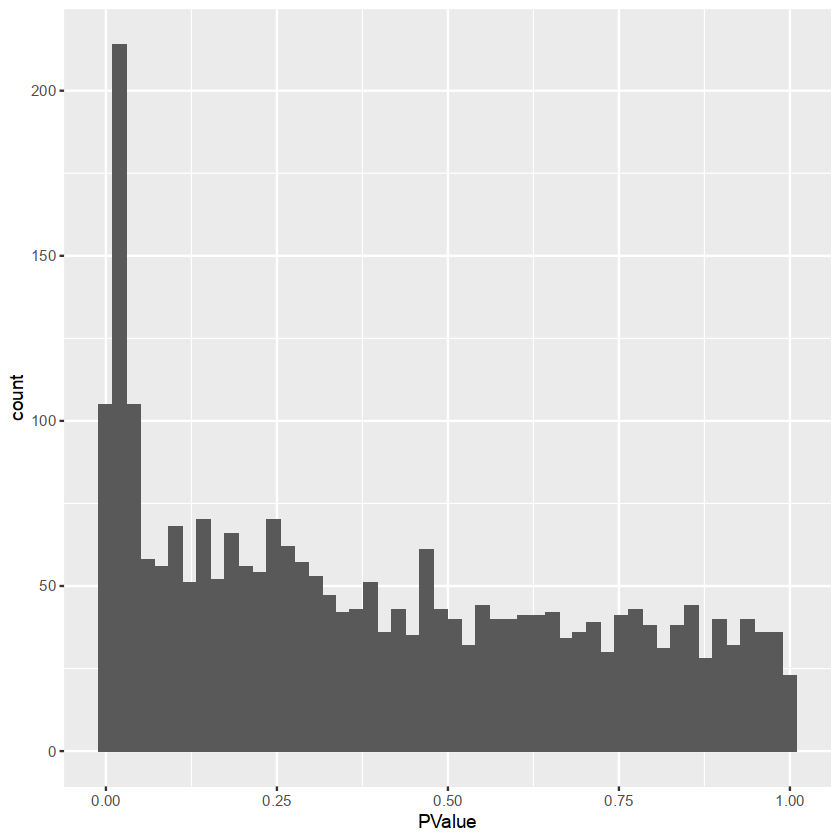

In [20]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=50)

Then we visualize the test results with a volcano plot (remember that each point here represents a neighbourhood, not a cell).

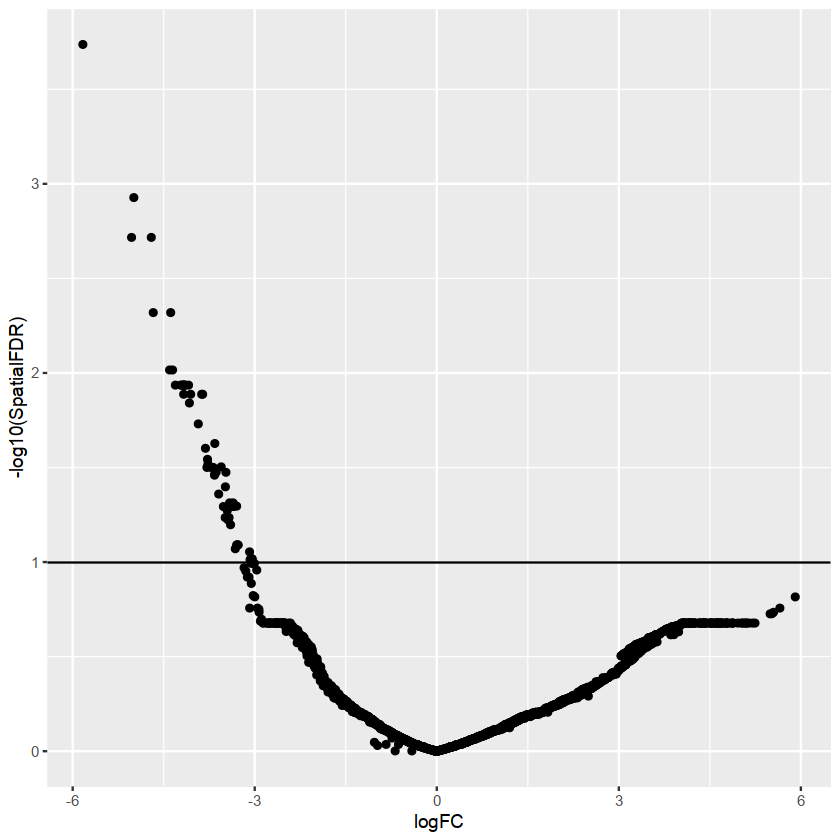

In [21]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

Looks like we have detected several neighbourhoods were there is a significant difference in cell abundances between disease status.

To visualize DA results relating them to the embedding of single cells, we can build an abstracted graph of neighbourhoods that we can superimpose on the single-cell embedding. Here each node represents a neighbourhood, while edges indicate how many cells two neighbourhoods have in common. Here the layout of nodes is determined by the position of the index cell in the UMAP embedding of all single-cells. The neighbourhoods displaying singificant DA are colored by their log-Fold Change.



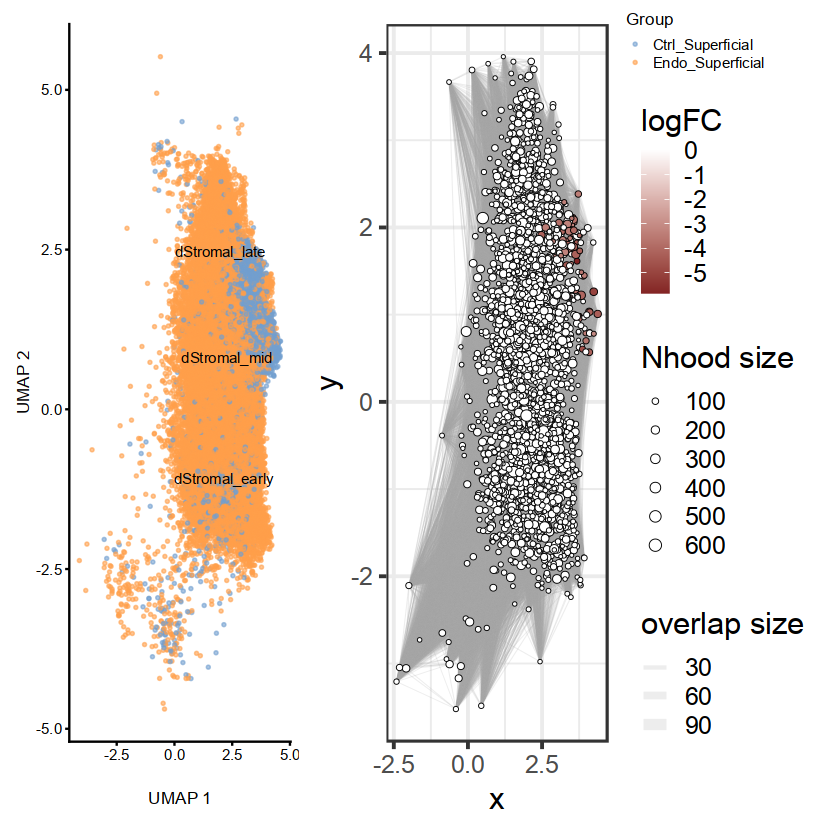

In [22]:
anndata_milo <- buildNhoodGraph(anndata_milo)

## Plot single-cell UMAP
umap_pl <- plotReducedDim(anndata_milo, dimred = "UMAP", colour_by="Group", text_by = "celltype", 
                          text_size = 3, point_size=0.5) + guides(fill="none")

## Plot neighbourhood graph
nh_graph_pl <- plotNhoodGraphDA(anndata_milo, da_results, layout="UMAP",alpha=0.1) 
  
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")+ theme_bw(18)

We might also be interested in visualizing wheather DA is particularly evident in certain cell types. To do this, we assign a cell type label to each neighbourhood by finding the most abundant cell type within cells in each neighbourhood. We can label neighbourhoods in the results data.frame using the function annotateNhoods. This also saves the fraction of cells harbouring the label.

In [23]:
da_results <- annotateNhoods(anndata_milo, da_results, coldata_col = "celltype")
head(da_results)

Converting celltype to factor...



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,celltype,celltype_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-1.7148753,10.65719,2.4112663,0.12047085,0.4900551,1,0.4967252,dStromal_early,0.9000000
2,1.0646056,9.57214,0.6399642,0.42372736,0.7503567,2,0.7524961,dStromal_late,0.6666667
3,1.5320190,10.71930,1.1653782,0.28035784,0.6440584,3,0.6475802,dStromal_late,0.4097222
4,1.4496121,10.57673,1.0685738,0.30127251,0.6535036,4,0.6563930,dStromal_late,0.8114286
5,0.7475116,11.58760,0.3036857,0.58158332,0.8369368,5,0.8373326,dStromal_mid,0.4968815
6,3.5723614,10.58644,4.3215494,0.03763743,0.2598628,6,0.2675063,dStromal_early,0.6606061


While neighbourhoods tend to be homogeneous, we can define a threshold for celltype_fraction to exclude neighbourhoods that are a mix of cell types.

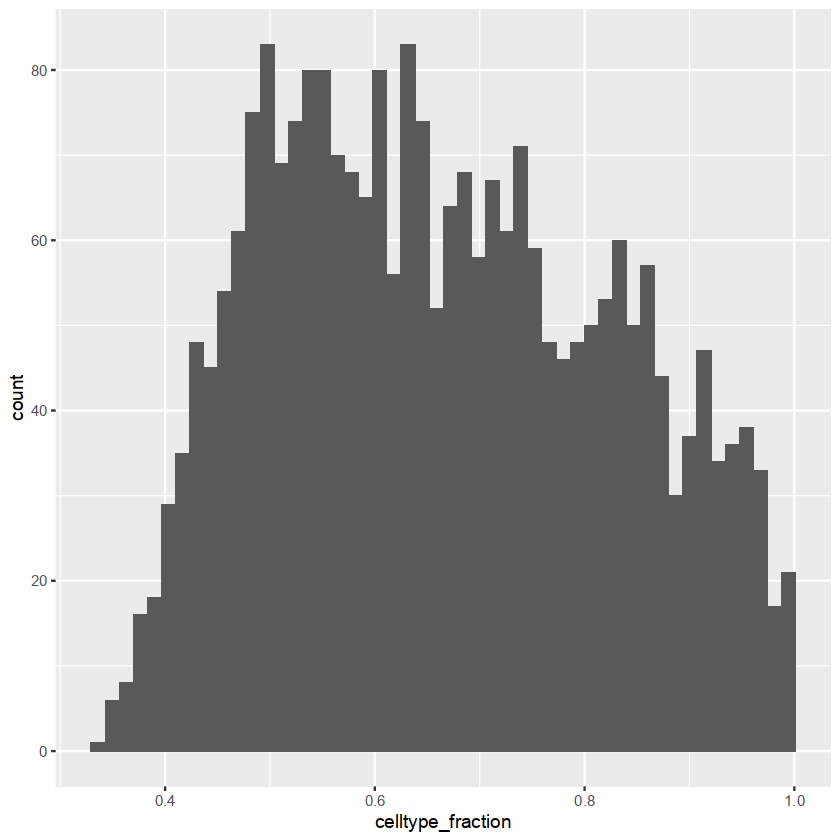

In [24]:
ggplot(da_results, aes(celltype_fraction)) + geom_histogram(bins=50)

In [25]:
da_results$celltype <- ifelse(da_results$celltype_fraction < 0.7, "Mixed", da_results$celltype)

Now we can visualize the distribution of DA Fold Changes in different cell types

In [26]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,celltype,celltype_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-1.7148753,10.65719,2.4112663,0.12047085,0.4900551,1,0.4967252,dStromal_early,0.9000000
2,1.0646056,9.57214,0.6399642,0.42372736,0.7503567,2,0.7524961,Mixed,0.6666667
3,1.5320190,10.71930,1.1653782,0.28035784,0.6440584,3,0.6475802,Mixed,0.4097222
4,1.4496121,10.57673,1.0685738,0.30127251,0.6535036,4,0.6563930,dStromal_late,0.8114286
5,0.7475116,11.58760,0.3036857,0.58158332,0.8369368,5,0.8373326,Mixed,0.4968815
6,3.5723614,10.58644,4.3215494,0.03763743,0.2598628,6,0.2675063,Mixed,0.6606061


Converting group.by to factor...



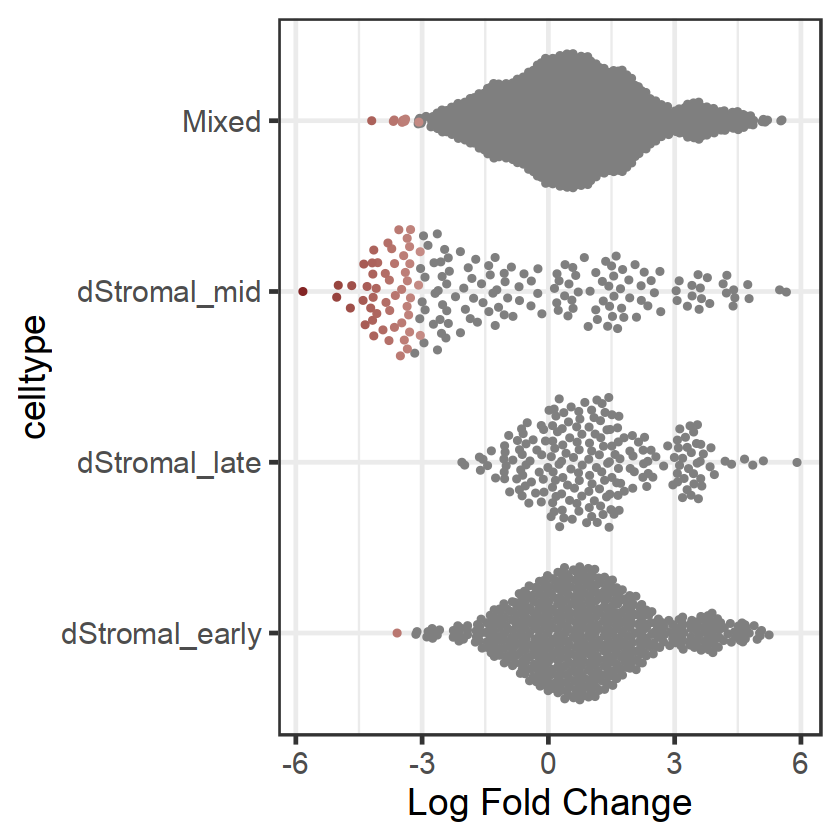

In [27]:
plotDAbeeswarm(da_results, group.by = "celltype")
saveRDS(da_results,  '/nfs/team292/lg18/endometriosis/MiloR_objects/nuclei_mesenchymal_SECRETORY_DAresults.rds')

This is already quite informative: we can see that certain early development cell types, such as epiblast and primitive streak, are enriched in the earliest time stage, while others are enriched later in development, such as ectoderm cells. Interestingly, we also see plenty of DA neighbourhood with a mixed label. This could indicate that transitional states show changes in abundance in time.

In [28]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/miloR-env/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SeuratObject_4.1.3          Seurat_4.3.0               
 [3] patchwork_1.1.2             dplyr_1.1.2                
 [5] scran_1.26.2                scater_1.26.1              
 [7] ggplot2_3.4.2               scuttle_1.8.4              
 [9] SingleCellExperiment_1.20.1 SummarizedExperiment_1.